### Predict Future Demand of Taxis in Different Taxi Zones in New York City
In this notebook, different algorithms will be leveraged to predict hourly number of taxi transactions in the 8 randomly selected taxi zones. Results are compared using root mean square error (RMSE).

In [1]:
# import libraries
import dask.dataframe as dd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
import torch
from torch import nn
import torch.nn.functional as F

### 1. Create dataset for experiment
Transaction records of the 8 randomly selected taxi zones (2 zone from each Tier) were extracted for the future transaction prediction task. <br>
During exploratory analysis, taxi zones were grouped into 4 tiers: <br>
Tier 1 zones have more than 250 daily transactions on average, accounting for 10.7% (28/260) of all taxi zones in NYC. <br>
Tier 2 zones have more than 50 daily transactions in average, accounting for 13.5% (35/260) of all taxi zones in NYC. <br>
Tier 3 zones have more than 25 daily transactions on average, accounting for 12.3% (32/260) of all taxi zones in NYC. <br>
Zones with less than 25 daily transactions on average were categorized as Tier 4, accounting for 63.5% (165/260) of all taxi zones in NYC.

In [2]:
zone_l = [25,    97, 106,  #Tier-1 zone and 2 neighbors
          166,   24, 41,   #Tier-1 zone and 2 neighbors
          228,   14, 111,  #Tier-2 zone and 2 neighbors
          83,    82, 157,  #Tier-2 zone and 2 neighbors
          177,   35, 77,   #Tier-3 zone and 2 neighbors
          78,    20, 60,   #Tier-3 zone and 2 neighbors
          216,   10, 180,  #Tier-4 zone and 2 neighbors
          184,   81, 51]   #Tier-4 zone and 2 neighbors

In [3]:
TXRRecords = dd.read_parquet('green_tripdata_2015-01.parquet')
                      #Zones  #Neighbors


TXRRecords_zone = TXRRecords[TXRRecords['PULocationID'].isin(zone_l)]


for y in range(2015, 2022):
    for m in ['01', '02', '03','04','05','06',
              '07', '08', '09','10','11','12']:
        if y == 2015 and m == '01':
            pass
        else:
            df = dd.read_parquet('green_tripdata_'+str(y)+'-'+ m + '.parquet')        
            df_zone = df[df['PULocationID'].isin(zone_l)]
            
            TXRRecords_zone = dd.multi.concat([TXRRecords_zone, df_zone])

In [4]:
TXRRecords_zone.shape[0].compute(), TXRRecords_zone.shape[1]

(13693355, 20)

Below, columns implying year, month, day, day of week and hours are added. Thus, the hourly number of transactions can  be calculated.

In [5]:
TXRRecords_zone['Yr'] = TXRRecords_zone['lpep_pickup_datetime'].dt.year
TXRRecords_zone['Month'] = TXRRecords_zone['lpep_pickup_datetime'].dt.month
TXRRecords_zone['Day'] = TXRRecords_zone['lpep_pickup_datetime'].dt.day
TXRRecords_zone['DayOfWeek'] = TXRRecords_zone['lpep_pickup_datetime'].dt.dayofweek
TXRRecords_zone['hour'] = TXRRecords_zone['lpep_pickup_datetime'].dt.hour

In [6]:
TXRRecords_zone.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,Yr,Month,Day,DayOfWeek,hour
6,1,2015-01-01 00:54:04,2015-01-01 01:15:52,N,1.0,25,7,1.0,10.80,32.0,...,0.3,33.30,2.0,1.0,None,2015,1,1,3,0
17,2,2015-01-01 00:24:32,2015-01-01 00:28:00,N,1.0,41,116,1.0,0.81,5.0,...,0.3,6.30,2.0,1.0,None,2015,1,1,3,0
22,2,2015-01-01 00:18:58,2015-01-01 00:33:30,N,1.0,41,168,3.0,2.72,12.0,...,0.3,13.30,2.0,1.0,None,2015,1,1,3,0
24,1,2015-01-01 00:20:32,2015-01-01 00:26:12,N,1.0,41,238,1.0,1.60,6.5,...,0.3,8.80,1.0,1.0,None,2015,1,1,3,0
25,1,2015-01-01 00:39:37,2015-01-01 00:46:12,N,1.0,166,239,1.0,2.00,8.0,...,0.3,12.05,1.0,1.0,None,2015,1,1,3,0


Hourly numbers of transactions were aggregated to create the data set for the prediction task.

In [7]:
TXR_Selected = TXRRecords_zone[['lpep_pickup_datetime','PULocationID', 'Yr','Month','Day','DayOfWeek','hour']] 
AggTXR = TXR_Selected.groupby(['PULocationID','Yr','Month','Day','DayOfWeek','hour',]).lpep_pickup_datetime.count().reset_index().compute()
AggTXR.shape

(830281, 7)

In [8]:
Dataset_raw = AggTXR[AggTXR['Yr'].isin([2015,2016,2017,2018,2019,2020,2021])].copy()
Dataset_raw.rename(columns={"lpep_pickup_datetime": "# Transactions"}, inplace = True)  
#AggTXR_Clean.to_csv('NYC_TaxiZone_Transactions_20220923.csv', index = False)

In [9]:
#Create datetime column for hourly number of transactions

def TXRHour(row):
    y = row['Yr']
    m = row['Month']
    d = row['Day']
    h = row['hour']
    return datetime.datetime(y, m, d, h, 0, 0)

Dataset_raw['TXRDatetime'] = Dataset_raw.apply(TXRHour, axis = 1)

In [10]:
Dataset_raw.head()

,PULocationID,Yr,Month,Day,DayOfWeek,hour,# Transactions,TXRDatetime
0,10,2015,1,1,3,1,2,2015-01-01 01:00:00
1,10,2015,1,1,3,3,1,2015-01-01 03:00:00
2,10,2015,1,1,3,5,1,2015-01-01 05:00:00
3,10,2015,1,1,3,11,1,2015-01-01 11:00:00
4,10,2015,1,1,3,12,1,2015-01-01 12:00:00


### Add 0s to time points with no transactions
The aggregated transaction records did not contain time points (zoomed to hours) with 0 transactions. Since time points with 0 transactions are also targets for prediction. These rows are added back to the dataframe for later prediction tasks.

In [11]:
TimeRange = pd.date_range('1/1/2015', periods=61368, freq='H')
AllTimePoint = pd.DataFrame(TimeRange, columns = ['TXRDatetime'])

AllTimePoint['Yr'] = AllTimePoint['TXRDatetime'].dt.year
AllTimePoint['Month'] = AllTimePoint['TXRDatetime'].dt.month
AllTimePoint['Day'] = AllTimePoint['TXRDatetime'].dt.day
AllTimePoint['DayOfWeek'] = AllTimePoint['TXRDatetime'].dt.dayofweek
AllTimePoint['hour'] = AllTimePoint['TXRDatetime'].dt.hour
AllTimePoint['# Transactions'] = 0
AllTimePoint.head()

,TXRDatetime,Yr,Month,Day,DayOfWeek,hour,# Transactions
0,2015-01-01 00:00:00,2015,1,1,3,0,0
1,2015-01-01 01:00:00,2015,1,1,3,1,0
2,2015-01-01 02:00:00,2015,1,1,3,2,0
3,2015-01-01 03:00:00,2015,1,1,3,3,0
4,2015-01-01 04:00:00,2015,1,1,3,4,0


In [12]:
DS = pd.DataFrame(columns = Dataset_raw.columns)

In [13]:
for z in zone_l:
    print("Zone: " + str(z))
    ZoneTXR = Dataset_raw[Dataset_raw['PULocationID']==z].copy()

    print("Zone shape:")
    print(ZoneTXR.shape)
    ZoneZeroTXR = AllTimePoint[~AllTimePoint['TXRDatetime'].isin(set(ZoneTXR['TXRDatetime']))].copy()

    ZoneZeroTXR['PULocationID'] = z                      

    print("Zero transaction time point shape:")
    print(ZoneZeroTXR.shape)
    
    ZoneTXR_all = pd.concat([ZoneTXR, ZoneZeroTXR])
    ZoneTXR_all = ZoneTXR_all.sort_values(by=['TXRDatetime'])
    
    DS = pd.concat([DS, ZoneTXR_all])
DS =  DS.reset_index()                               

Zone: 25
Zone shape:
(52769, 8)
Zero transaction time point shape:
(8599, 8)
Zone: 97
Zone shape:
(54131, 8)
Zero transaction time point shape:
(7237, 8)
Zone: 106
Zone shape:
(38810, 8)
Zero transaction time point shape:
(22558, 8)
Zone: 166
Zone shape:
(56254, 8)
Zero transaction time point shape:
(5114, 8)
Zone: 24
Zone shape:
(43001, 8)
Zero transaction time point shape:
(18367, 8)
Zone: 41
Zone shape:
(58821, 8)
Zero transaction time point shape:
(2547, 8)
Zone: 228
Zone shape:
(39483, 8)
Zero transaction time point shape:
(21885, 8)
Zone: 14
Zone shape:
(34282, 8)
Zero transaction time point shape:
(27086, 8)
Zone: 111
Zone shape:
(3411, 8)
Zero transaction time point shape:
(57957, 8)
Zone: 83
Zone shape:
(47796, 8)
Zero transaction time point shape:
(13572, 8)
Zone: 82
Zone shape:
(56572, 8)
Zero transaction time point shape:
(4796, 8)
Zone: 157
Zone shape:
(23449, 8)
Zero transaction time point shape:
(37919, 8)
Zone: 177
Zone shape:
(39954, 8)
Zero transaction time point shap

In [14]:
DS.head(10)

,index,PULocationID,Yr,Month,Day,DayOfWeek,hour,# Transactions,TXRDatetime
0,1847,25,2015,1,1,3,0,124,2015-01-01 00:00:00
1,1848,25,2015,1,1,3,1,110,2015-01-01 01:00:00
2,1849,25,2015,1,1,3,2,86,2015-01-01 02:00:00
3,1850,25,2015,1,1,3,3,109,2015-01-01 03:00:00
4,1851,25,2015,1,1,3,4,57,2015-01-01 04:00:00
5,1852,25,2015,1,1,3,5,46,2015-01-01 05:00:00
6,1853,25,2015,1,1,3,6,14,2015-01-01 06:00:00
7,1854,25,2015,1,1,3,7,21,2015-01-01 07:00:00
8,1855,25,2015,1,1,3,8,6,2015-01-01 08:00:00
9,1856,25,2015,1,1,3,9,11,2015-01-01 09:00:00


In [15]:
DS.tail(10)

,index,PULocationID,Yr,Month,Day,DayOfWeek,hour,# Transactions,TXRDatetime
1472822,61358,51,2021,12,31,4,14,0,2021-12-31 14:00:00
1472823,61359,51,2021,12,31,4,15,0,2021-12-31 15:00:00
1472824,61360,51,2021,12,31,4,16,0,2021-12-31 16:00:00
1472825,61361,51,2021,12,31,4,17,0,2021-12-31 17:00:00
1472826,61362,51,2021,12,31,4,18,0,2021-12-31 18:00:00
1472827,61363,51,2021,12,31,4,19,0,2021-12-31 19:00:00
1472828,61364,51,2021,12,31,4,20,0,2021-12-31 20:00:00
1472829,61365,51,2021,12,31,4,21,0,2021-12-31 21:00:00
1472830,61366,51,2021,12,31,4,22,0,2021-12-31 22:00:00
1472831,826958,51,2021,12,31,4,23,1,2021-12-31 23:00:00


In [16]:
DS=  DS.astype({'PULocationID': 'int32', '# Transactions': 'int32'})
DS.dtypes

index                      int64
PULocationID               int32
Yr                        object
Month                     object
Day                       object
DayOfWeek                 object
hour                      object
# Transactions             int32
TXRDatetime       datetime64[ns]
dtype: object

## 2. The prediction task
The goal is to <u>predict future hourly taxi transactions in each zone</u>. We will use the <u> data of December 2019 to test</u> different algorithms because there is a sharp decline of transactions since early 2021, which deviates from previous patterns. To predict the number of transactions in 2020 and 2021, the model needs to be adjusted. For example, the output value can be discounted. To measure how prediction matches the actual number of transactions, <b> Root Mean Square Error (RMSE) </b> would be used. <br>
${RMSE} =  \sqrt{\frac {\sum \limits _{i=1} ^{n} {(\hat{Y}_{i} - {Y}_{i})}^{2}} {{n}}}$

## 3. Time Series Models
Based solely on number of transactions in previous time points, we can predict future number of transactions leveraging time series models (e.g. exponential smoothing, autoregressive models...etc). We will first evaluate the performance of time series models.

## Stationarity
Many time series models require the data to meet stationary prerequisites. Roughly speaking, a time series data is stationary if the mean and variance of the sequence are constant. Here, we first apply the Augmented Dickey–Fuller (ADF) test to see if the overall number of taxi transactions in selected zones are stationary. Then, we apply 4 models: Exponential Smoothing, Autoregressive model (AR), Moving Average model (MA) and the combined model of ARMA on selected zones and check their results.

In [17]:
#Select December 2015 data from selected taxi zones to test model performance
DatasetCon = DS.groupby(['Yr', 'Month','Day', 'hour'])['# Transactions'].sum().reset_index()
DatasetCon = DatasetCon[(DatasetCon['Yr']==2019)&(DatasetCon['Month']==12)]
DatasetCon['TXRDatetime'] = DatasetCon.apply(TXRHour, axis = 1)
DatasetCon = DatasetCon.set_index('TXRDatetime')
DatasetCon = DatasetCon[['# Transactions']]
DatasetCon.head()

,# Transactions
TXRDatetime,
2019-12-01 00:00:00,116
2019-12-01 01:00:00,90
2019-12-01 02:00:00,68
2019-12-01 03:00:00,31
2019-12-01 04:00:00,53


### Augmented Dickey-Fuller (ADF) Test 
The p-value of the ADF test is smaller than .05, rejecting the hypothesis that the time series data is non-stationary. Time series models will be applied to fit the number of transactions in December 2019 to see the performance.

In [18]:
ADFuller_result_all = adfuller(DatasetCon['# Transactions'])
print('Overall ADF Statistic: %f' % ADFuller_result_all[0])
print('p-value: %f' % ADFuller_result_all[1])

Overall ADF Statistic: -2.961862
p-value: 0.038613


### The Autocorrelation Function (ACF)
The ACF can be used to see if the number of transactions on previous time points are correlated with the current number of transactions. We use data from t-1 to t-6 to feed into the moving average model according to the result of ACF.

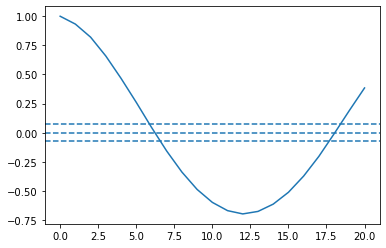

In [19]:
lag_acf = acf(DatasetCon.values, nlags = 20)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(DatasetCon)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(DatasetCon)),linestyle='--')

### The Partial Autocorrelation Function (PACF)
The PACF can be used to see if the number of transactions on given previous timepoints is independently correlated with to the current number of transactions. Here, we used the number of transactions at t-1 and t-2 to feed into the autoregressive model.

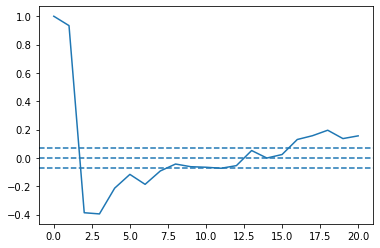

In [20]:
lag_pacf = pacf(DatasetCon.values, nlags = 20)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(DatasetCon)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(DatasetCon)),linestyle='--')

In [21]:
import warnings
warnings.simplefilter('ignore')


#Select December 2015 data from selected taxi zones to test model performance
TimeSeriesResult_l = list()

for z in [25,166,228,83,177,78,216,184]:
    
    #Select December 2015 data
    TSData_zone = DS[DS['PULocationID']==z].copy()   
    TSData_zone = TSData_zone[(TSData_zone['Yr']==2019)&(TSData_zone['Month']==12)]
    
    #ADFuller Test
    ADFuller_zone = adfuller(TSData_zone['# Transactions'])
    
    TSData_zone = TSData_zone.set_index('TXRDatetime')
    TSData_zone.index = pd.DatetimeIndex(TSData_zone.index).to_period('h')
    TSData_zone = TSData_zone[['# Transactions']]    
    
    #Exponential Smoothing
    model_ExpSmooth = SimpleExpSmoothing(TSData_zone)
    model_ExpSmooth_fit = model_ExpSmooth.fit(smoothing_level=.1)
    
    RMSE_ExpSmooth = mean_squared_error(TSData_zone, model_ExpSmooth_fit.fittedvalues, squared = True)

    #Auto regressive
    model_AR = ARIMA(TSData_zone, order=(2, 0, 0))  
    results_AR = model_AR.fit()  
    
    RMSE_AR = mean_squared_error(TSData_zone, results_AR.fittedvalues, squared = True)
    
    #Moving Average
    model_MA = ARIMA(TSData_zone, order=(0, 0, 6))  
    results_MA = model_MA.fit()      
    
    RMSE_MA = mean_squared_error(TSData_zone, results_MA.fittedvalues, squared = True)

    #ARMA
    model_ARMA = ARIMA(TSData_zone, order=(2, 0, 6))  
    results_ARMA = model_ARMA.fit()        

    RMSE_ARMA = mean_squared_error(TSData_zone, results_ARMA.fittedvalues, squared = True)
    
    TimeSeriesResult_l.append([z, ADFuller_zone[1], RMSE_ExpSmooth, RMSE_AR, RMSE_MA, RMSE_ARMA])
    
    #TSData_zone.plot(figsize = (16,5))
    #plt.title('Taxi Zone ' + str(z) + ' Transaction Trend Dec 2019', fontsize=18)
    #plt.plot(model_ExpSmooth_fit.fittedvalues, color='purple')
    #plt.plot(results_AR.fittedvalues, color='red')    
    #plt.plot(results_MA.fittedvalues, color='orange')
    #plt.plot(results_ARMA.fittedvalues, color='green')
    #plt.show()

In [22]:
TimeSeriesResult_df = pd.DataFrame(TimeSeriesResult_l, columns = ['Zone', 'ADF p-values', 'Exponential Smoothing RMSE','AR RMSE', 'MA RMSE', 'ARMA RMSE'])
TimeSeriesResult_df

,Zone,ADF p-values,Exponential Smoothing RMSE,AR RMSE,MA RMSE,ARMA RMSE
0,25,1.063261e-04,69.533460,24.268460,23.635850,18.221991
1,166,7.251957e-02,296.497885,79.258082,77.939850,59.319991
2,228,2.710941e-06,1.515720,1.302933,1.285355,1.188091
3,83,7.644342e-05,7.160822,5.229565,5.184692,4.512232
4,177,2.794055e-07,2.899295,2.324803,2.284440,2.277562
5,78,5.372673e-08,1.886244,1.618301,1.606744,1.594122
6,216,4.948673e-07,1.433575,1.308067,1.269475,1.136465
7,184,0.000000e+00,0.029135,0.027542,0.027472,0.027446


### Time series model prediction results
From the performance summary below, we can see that the ARMA model yielded the best results (lowest RMSE). We will compare these results with other machine learning models.

In [23]:
def ZoneTier(z):
    if z in [25, 166]:
        return 1
    elif z in [228, 83]:
        return 2
    elif z in [177, 78]:
        return 3    
    elif z in [216, 184]:
        return 4    

TimeSeriesResult_df['ZoneTier'] = TimeSeriesResult_df['Zone'].apply(ZoneTier)
TimeSeriesResult_df_Tier = TimeSeriesResult_df.groupby(['ZoneTier'])[['Exponential Smoothing RMSE', 'AR RMSE', 'MA RMSE', 'ARMA RMSE']].mean().reset_index()
TimeSeriesResult_df_Tier

,ZoneTier,Exponential Smoothing RMSE,AR RMSE,MA RMSE,ARMA RMSE
0,1,183.015672,51.763271,50.787850,38.770991
1,2,4.338271,3.266249,3.235023,2.850162
2,3,2.392769,1.971552,1.945592,1.935842
3,4,0.731355,0.667805,0.648474,0.581955


In [24]:
TimeSeriesResult_df_Tier.describe()

,ZoneTier,Exponential Smoothing RMSE,AR RMSE,MA RMSE,ARMA RMSE
count,4.000000,4.000000,4.000000,4.000000,4.000000
mean,2.500000,47.619517,14.417219,14.154235,11.034737
std,1.290994,90.276139,24.919957,24.445228,18.514297
min,1.000000,0.731355,0.667805,0.648474,0.581955
25%,1.750000,1.977416,1.645615,1.621312,1.597370
50%,2.500000,3.365520,2.618901,2.590308,2.393002
75%,3.250000,49.007621,15.390505,15.123230,11.830369
max,4.000000,183.015672,51.763271,50.787850,38.770991


## 3. Other Machine Learning (ML) Models
Machine learning (ML) models (e.g. random forest shown below) can take into different indices (called features in ML terminologies) for prediction. From exploratory analysis, we see that weekly and daily number of transactions fluctuate regularly. Thus, we leverage this information for transaction prediction. Besides the <u>number of transactions in the given taxi zone</u> (<u>t-1 to t-6)</u>, as used in the time series models), <u>month</u>, <u>day of week</u>, <u>hour of day </u> and <u>number of transactions in 2 randomly selected neighboring taxi zones(t-1 to t-6)</u> were used as features for number of transaction predictions for every taxi zone. 

In [25]:
zone_dict = {25: [97, 106],  #Tier-1 zone and 2 neighbors
             166:[24, 41] ,  #Tier-1 zone and 2 neighbors
             228:[14, 111],  #Tier-2 zone and 2 neighbors
             83: [82, 157],  #Tier-2 zone and 2 neighbors
             177:[35, 77] ,  #Tier-3 zone and 2 neighbors
             78: [20, 60] ,  #Tier-3 zone and 2 neighbors
             216:[10, 180],  #Tier-4 zone and 2 neighbors
             184:[81, 51]}   #Tier-4 zone and 2 neighbors

### a. Create dataset for ML prediction

In [26]:
# add columns of different time difference

Dataset_ML_raw = DS.copy()
Dataset_ML_raw['t-1'] = Dataset_ML_raw['TXRDatetime'] + pd.Timedelta(hours=-1)
Dataset_ML_raw['t-2'] = Dataset_ML_raw['TXRDatetime'] + pd.Timedelta(hours=-2)
Dataset_ML_raw['t-3'] = Dataset_ML_raw['TXRDatetime'] + pd.Timedelta(hours=-3)
Dataset_ML_raw['t-4'] = Dataset_ML_raw['TXRDatetime'] + pd.Timedelta(hours=-4)
Dataset_ML_raw['t-5'] = Dataset_ML_raw['TXRDatetime'] + pd.Timedelta(hours=-5)
Dataset_ML_raw['t-6'] = Dataset_ML_raw['TXRDatetime'] + pd.Timedelta(hours=-6)
Dataset_ML_raw.rename(columns={"# Transactions": "# TXR"}, inplace = True)  
Dataset_ML_raw.head()

,index,PULocationID,Yr,Month,Day,DayOfWeek,hour,# TXR,TXRDatetime,t-1,t-2,t-3,t-4,t-5,t-6
0,1847,25,2015,1,1,3,0,124,2015-01-01 00:00:00,2014-12-31 23:00:00,2014-12-31 22:00:00,2014-12-31 21:00:00,2014-12-31 20:00:00,2014-12-31 19:00:00,2014-12-31 18:00:00
1,1848,25,2015,1,1,3,1,110,2015-01-01 01:00:00,2015-01-01 00:00:00,2014-12-31 23:00:00,2014-12-31 22:00:00,2014-12-31 21:00:00,2014-12-31 20:00:00,2014-12-31 19:00:00
2,1849,25,2015,1,1,3,2,86,2015-01-01 02:00:00,2015-01-01 01:00:00,2015-01-01 00:00:00,2014-12-31 23:00:00,2014-12-31 22:00:00,2014-12-31 21:00:00,2014-12-31 20:00:00
3,1850,25,2015,1,1,3,3,109,2015-01-01 03:00:00,2015-01-01 02:00:00,2015-01-01 01:00:00,2015-01-01 00:00:00,2014-12-31 23:00:00,2014-12-31 22:00:00,2014-12-31 21:00:00
4,1851,25,2015,1,1,3,4,57,2015-01-01 04:00:00,2015-01-01 03:00:00,2015-01-01 02:00:00,2015-01-01 01:00:00,2015-01-01 00:00:00,2014-12-31 23:00:00,2014-12-31 22:00:00


In [27]:
#Create dataframe
Dataset_ML = pd.DataFrame(columns = ['PULocationID', 'Yr','Month', 'Day', 
                                     'DayOfWeek', 'hour', 
                                     'TXRDatetime', 'TXRTimePrev',
                                     
                                     '# TXR',#Target
                                     
                                     '# TXR_t-1','# TXR_t-2','# TXR_t-3',
                                     '# TXR_t-4','# TXR_t-5','# TXR_t-6',
                                     
                                     'Neighbor1 # TXR_t-1','Neighbor1 # TXR_t-2','Neighbor1 # TXR_t-3',
                                     'Neighbor1 # TXR_t-4','Neighbor1 # TXR_t-5','Neighbor1 # TXR_t-6',
                                     
                                     'Neighbor2 # TXR_t-1','Neighbor2 # TXR_t-2','Neighbor2 # TXR_t-3',
                                     'Neighbor2 # TXR_t-4','Neighbor2 # TXR_t-5','Neighbor2 # TXR_t-6'])

In [28]:
# add neighboring taxi zone transaction trend for prediction

for z in zone_dict:
    print('Transforming Zone ' + str(z) + ' transaction records...')
    
    zoneDataset = Dataset_ML_raw[Dataset_ML_raw['PULocationID']==z][['PULocationID','Yr', 'Month', 'Day', 
                                     'DayOfWeek', 'hour', '# TXR', 'TXRDatetime', 
                                     't-1', 't-2', 't-3', 't-4', 't-5', 't-6']]
    for tDif in range(1, 7): 
        zoneTXRprev = Dataset_ML_raw[Dataset_ML_raw['PULocationID']==z][['TXRDatetime', '# TXR']]
    
        zoneTXRprev.rename(columns={'TXRDatetime': 't-'+str(tDif),
                                '# TXR': '# TXR_t-'+str(tDif)}, inplace = True)  
        zoneDataset = zoneDataset.merge(zoneTXRprev, how = 'left', on = 't-'+str(tDif))

        #Neighbor 1
        Neighbor1_prev = Dataset_ML_raw[Dataset_ML_raw['PULocationID']==zone_dict[z][0]][['TXRDatetime', '# TXR']]                               
        Neighbor1_prev.rename(columns={'TXRDatetime': 't-'+str(tDif),
                                    '# TXR': 'Neighbor1 # TXR_t-'+str(tDif)}, inplace = True)  
                                    
        zoneDataset = zoneDataset.merge(Neighbor1_prev, how = 'left', on = 't-'+str(tDif))                                                           

        #Neighbor 2                                
        Neighbor2_prev = Dataset_ML_raw[Dataset_ML_raw['PULocationID']==zone_dict[z][1]][['TXRDatetime', '# TXR']]                               
        Neighbor2_prev.rename(columns={'TXRDatetime': 't-'+str(tDif),
                                    '# TXR': 'Neighbor2 # TXR_t-'+str(tDif)}, inplace = True)  
        
        zoneDataset = zoneDataset.merge(Neighbor2_prev, how = 'left', on = 't-'+str(tDif))                                                           

    zoneDataset.fillna(0, inplace = True)
    Dataset_ML = pd.concat([Dataset_ML, zoneDataset])
    
    

Transforming Zone 25 transaction records...
Transforming Zone 166 transaction records...
Transforming Zone 228 transaction records...
Transforming Zone 83 transaction records...
Transforming Zone 177 transaction records...
Transforming Zone 78 transaction records...
Transforming Zone 216 transaction records...
Transforming Zone 184 transaction records...


In [29]:
Dataset_ML.head()

,PULocationID,Yr,Month,Day,DayOfWeek,hour,TXRDatetime,TXRTimePrev,# TXR,# TXR_t-1,...,Neighbor2 # TXR_t-3,Neighbor2 # TXR_t-4,Neighbor2 # TXR_t-5,Neighbor2 # TXR_t-6,t-1,t-2,t-3,t-4,t-5,t-6
0,25,2015,1,1,3,0,2015-01-01 00:00:00,NaN,124,0.0,...,0.0,0.0,0.0,0.0,2014-12-31 23:00:00,2014-12-31 22:00:00,2014-12-31 21:00:00,2014-12-31 20:00:00,2014-12-31 19:00:00,2014-12-31 18:00:00
1,25,2015,1,1,3,1,2015-01-01 01:00:00,NaN,110,124.0,...,0.0,0.0,0.0,0.0,2015-01-01 00:00:00,2014-12-31 23:00:00,2014-12-31 22:00:00,2014-12-31 21:00:00,2014-12-31 20:00:00,2014-12-31 19:00:00
2,25,2015,1,1,3,2,2015-01-01 02:00:00,NaN,86,110.0,...,0.0,0.0,0.0,0.0,2015-01-01 01:00:00,2015-01-01 00:00:00,2014-12-31 23:00:00,2014-12-31 22:00:00,2014-12-31 21:00:00,2014-12-31 20:00:00
3,25,2015,1,1,3,3,2015-01-01 03:00:00,NaN,109,86.0,...,43.0,0.0,0.0,0.0,2015-01-01 02:00:00,2015-01-01 01:00:00,2015-01-01 00:00:00,2014-12-31 23:00:00,2014-12-31 22:00:00,2014-12-31 21:00:00
4,25,2015,1,1,3,4,2015-01-01 04:00:00,NaN,57,109.0,...,39.0,43.0,0.0,0.0,2015-01-01 03:00:00,2015-01-01 02:00:00,2015-01-01 01:00:00,2015-01-01 00:00:00,2014-12-31 23:00:00,2014-12-31 22:00:00


### a. Train model using historical records
Transaction data from January 2015 to November 2019 were used to train the random forest regressor model. 

In [30]:
TrainSet = Dataset_ML[Dataset_ML['Yr'].isin([2015, 2016, 2017, 2018, 2019])]
TrainSet  = TrainSet[~((TrainSet['Yr']==2019)&(TrainSet['Month']==12))]
TrainSet.shape

(344640, 33)

### Random Forest Regression
Random forest regression uses bagging to generate different sets of rules to group data points. Then, the number of transactions of those data points grouped together would be used to generate predictions for new data points with similar characteristics.

In [31]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

X_train = TrainSet[['PULocationID','Month', 'DayOfWeek', 'hour',
                    '# TXR_t-1','# TXR_t-2','# TXR_t-3',
                    '# TXR_t-4','# TXR_t-5','# TXR_t-6',
                                     
                    'Neighbor1 # TXR_t-1','Neighbor1 # TXR_t-2','Neighbor1 # TXR_t-3',
                    'Neighbor1 # TXR_t-4','Neighbor1 # TXR_t-5','Neighbor1 # TXR_t-6',
                                     
                    'Neighbor2 # TXR_t-1','Neighbor2 # TXR_t-2','Neighbor2 # TXR_t-3',
                    'Neighbor2 # TXR_t-4','Neighbor2 # TXR_t-5','Neighbor2 # TXR_t-6']]

y_train = TrainSet['# TXR'].ravel()
# fit the regressor with x and y data
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Transaction records of December 2019 are used to test model performance.

In [32]:
TestSet = Dataset_ML[(Dataset_ML['Yr']==2019)&(Dataset_ML['Month']==12)]
print(TestSet.shape)
TestSet.head()

(5952, 33)


,PULocationID,Yr,Month,Day,DayOfWeek,hour,TXRDatetime,TXRTimePrev,# TXR,# TXR_t-1,...,Neighbor2 # TXR_t-3,Neighbor2 # TXR_t-4,Neighbor2 # TXR_t-5,Neighbor2 # TXR_t-6,t-1,t-2,t-3,t-4,t-5,t-6
43080,25,2019,12,1,6,0,2019-12-01 00:00:00,NaN,7,9.0,...,0.0,4.0,1.0,0.0,2019-11-30 23:00:00,2019-11-30 22:00:00,2019-11-30 21:00:00,2019-11-30 20:00:00,2019-11-30 19:00:00,2019-11-30 18:00:00
43081,25,2019,12,1,6,1,2019-12-01 01:00:00,NaN,9,7.0,...,0.0,0.0,4.0,1.0,2019-12-01 00:00:00,2019-11-30 23:00:00,2019-11-30 22:00:00,2019-11-30 21:00:00,2019-11-30 20:00:00,2019-11-30 19:00:00
43082,25,2019,12,1,6,2,2019-12-01 02:00:00,NaN,4,9.0,...,0.0,0.0,0.0,4.0,2019-12-01 01:00:00,2019-12-01 00:00:00,2019-11-30 23:00:00,2019-11-30 22:00:00,2019-11-30 21:00:00,2019-11-30 20:00:00
43083,25,2019,12,1,6,3,2019-12-01 03:00:00,NaN,1,4.0,...,2.0,0.0,0.0,0.0,2019-12-01 02:00:00,2019-12-01 01:00:00,2019-12-01 00:00:00,2019-11-30 23:00:00,2019-11-30 22:00:00,2019-11-30 21:00:00
43084,25,2019,12,1,6,4,2019-12-01 04:00:00,NaN,2,1.0,...,2.0,2.0,0.0,0.0,2019-12-01 03:00:00,2019-12-01 02:00:00,2019-12-01 01:00:00,2019-12-01 00:00:00,2019-11-30 23:00:00,2019-11-30 22:00:00


In [33]:
Features_clmn =['PULocationID','Month', 'DayOfWeek', 'hour',
                '# TXR_t-1','# TXR_t-2','# TXR_t-3',
                '# TXR_t-4','# TXR_t-5','# TXR_t-6',
                                     
                'Neighbor1 # TXR_t-1','Neighbor1 # TXR_t-2','Neighbor1 # TXR_t-3',
                'Neighbor1 # TXR_t-4','Neighbor1 # TXR_t-5','Neighbor1 # TXR_t-6',
                                     
                'Neighbor2 # TXR_t-1','Neighbor2 # TXR_t-2','Neighbor2 # TXR_t-3',
                'Neighbor2 # TXR_t-4','Neighbor2 # TXR_t-5','Neighbor2 # TXR_t-6']

Target_clmn = ['# TXR']

### Prediction results by zones and tiers
Below are the aggregated RMSE by taxi zone and tiers to analyze further model performance on taxi zones with different magnitude of transaction.

In [34]:
#Select December 2015 data from selected taxi zones to test model performance
RFResult_l = list()

for z in [25,166,228,83,177,78,216,184]:
    TestSet_zone = TestSet[TestSet['PULocationID']==z]
    
    predictionRF_zone = regressor.predict(TestSet_zone[Features_clmn])
    RMSE_RF = mean_squared_error(TestSet_zone[Target_clmn], predictionRF_zone, squared = True)
    
    RFResult_l.append([z, RMSE_RF])

In [35]:
RFResult_df = pd.DataFrame(RFResult_l, columns = ['Zone', 'RF_RMSE'])
RFResult_df

,Zone,RF_RMSE
0,25,19.453873
1,166,45.592056
2,228,1.734120
3,83,4.501155
4,177,2.371503
5,78,1.587303
6,216,1.429447
7,184,0.102887


In [36]:
RFResult_df['ZoneTier'] = RFResult_df['Zone'].apply(ZoneTier)
RFResult_df_Tier = RFResult_df.groupby(['ZoneTier'])['RF_RMSE'].mean().reset_index()
RFResult_df_Tier

,ZoneTier,RF_RMSE
0,1,32.522964
1,2,3.117637
2,3,1.979403
3,4,0.766167


In [37]:
RFResult_df_Tier.describe()

,ZoneTier,RF_RMSE
count,4.000000,4.000000
mean,2.500000,9.596543
std,1.290994,15.314409
min,1.000000,0.766167
25%,1.750000,1.676094
50%,2.500000,2.548520
75%,3.250000,10.468969
max,4.000000,32.522964


### Long Short-Term Memory  
Long short-term memory (LSTM) is a variant of recurrent neural network (RNN). The model can be trained using time series data. The update gate and forget gate design enable the LSTM model to "remember" important time points in the series, overcoming the vanishing gradient problem of the vanilla RNN model. Below are the details of applying the LSTM model for taxi transaction prediction. 

In [38]:
Dataset_DL = Dataset_ML[['PULocationID', 'TXRDatetime', 'Month', 'DayOfWeek', 'hour',
                       '# TXR', '# TXR_t-1', 'Neighbor1 # TXR_t-1','Neighbor2 # TXR_t-1']].copy()

Dataset_DL=  Dataset_DL.astype({'# TXR': 'float64'})
Dataset_DL =  Dataset_DL.reset_index(drop=True)
print(Dataset_DL.shape)
Dataset_DL.tail()

(490944, 9)


,PULocationID,TXRDatetime,Month,DayOfWeek,hour,# TXR,# TXR_t-1,Neighbor1 # TXR_t-1,Neighbor2 # TXR_t-1
490939,184,2021-12-31 19:00:00,12,4,19,0.0,0.0,0.0,0.0
490940,184,2021-12-31 20:00:00,12,4,20,0.0,0.0,0.0,0.0
490941,184,2021-12-31 21:00:00,12,4,21,0.0,0.0,0.0,0.0
490942,184,2021-12-31 22:00:00,12,4,22,0.0,0.0,0.0,0.0
490943,184,2021-12-31 23:00:00,12,4,23,0.0,0.0,1.0,0.0


In [39]:
Dataset_DL.head(20)

,PULocationID,TXRDatetime,Month,DayOfWeek,hour,# TXR,# TXR_t-1,Neighbor1 # TXR_t-1,Neighbor2 # TXR_t-1
0,25,2015-01-01 00:00:00,1,3,0,124.0,0.0,0.0,0.0
1,25,2015-01-01 01:00:00,1,3,1,110.0,124.0,124.0,43.0
2,25,2015-01-01 02:00:00,1,3,2,86.0,110.0,101.0,39.0
3,25,2015-01-01 03:00:00,1,3,3,109.0,86.0,88.0,41.0
4,25,2015-01-01 04:00:00,1,3,4,57.0,109.0,74.0,40.0
5,25,2015-01-01 05:00:00,1,3,5,46.0,57.0,79.0,33.0
6,25,2015-01-01 06:00:00,1,3,6,14.0,46.0,31.0,16.0
7,25,2015-01-01 07:00:00,1,3,7,21.0,14.0,20.0,7.0
8,25,2015-01-01 08:00:00,1,3,8,6.0,21.0,18.0,1.0
9,25,2015-01-01 09:00:00,1,3,9,11.0,6.0,8.0,0.0


### One Hot Encoding
One cannot put categorical variables into the LSTM model for training due to the model's nature. One way to work around this problem is one hot encoding. For example, a column of 3 colors ['Color': 'Red', 'Blue', 'Green'] can be transformed in to 3 columns ['Color_Red': 1, 0, 0], ['Color_Blue': 0, 1, 0] and ['Color_Green':0,0,1]. The resulting longer sequence can be used to train the LSTM model. Here, we transformed the dataframe for model training using one hot encoding.

In [40]:
#One hot encoding
Dataset_DL = pd.concat([Dataset_DL,pd.get_dummies(Dataset_DL['PULocationID'], prefix='Z')],axis=1)
Dataset_DL = pd.concat([Dataset_DL,pd.get_dummies(Dataset_DL['Month'], prefix='M')],axis=1)
Dataset_DL = pd.concat([Dataset_DL,pd.get_dummies(Dataset_DL['DayOfWeek'], prefix='D')],axis=1)
Dataset_DL = pd.concat([Dataset_DL,pd.get_dummies(Dataset_DL['hour'], prefix='H')],axis=1)
print(Dataset_DL.shape)
Dataset_DL.columns

(490944, 60)


Index(['PULocationID', 'TXRDatetime', 'Month', 'DayOfWeek', 'hour', '# TXR',
       '# TXR_t-1', 'Neighbor1 # TXR_t-1', 'Neighbor2 # TXR_t-1', 'Z_25',
       'Z_78', 'Z_83', 'Z_166', 'Z_177', 'Z_184', 'Z_216', 'Z_228', 'M_1',
       'M_2', 'M_3', 'M_4', 'M_5', 'M_6', 'M_7', 'M_8', 'M_9', 'M_10', 'M_11',
       'M_12', 'D_0', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'H_0', 'H_1',
       'H_2', 'H_3', 'H_4', 'H_5', 'H_6', 'H_7', 'H_8', 'H_9', 'H_10', 'H_11',
       'H_12', 'H_13', 'H_14', 'H_15', 'H_16', 'H_17', 'H_18', 'H_19', 'H_20',
       'H_21', 'H_22', 'H_23'],
      dtype='object')

### Train-test split 
As with other models, transaction records of December 2019 are used to test model performance. Data from 2015 to 2018 are used as the training dataset.

In [41]:
Train_df = Dataset_DL[Dataset_DL['TXRDatetime']<='2018-12-31'].copy()
Train_df = Train_df.set_index('TXRDatetime')
print("Train dataset shape:")
print(Train_df.shape)

Test_df = Dataset_DL[(Dataset_DL['TXRDatetime']>'2019-11-30') & (Dataset_DL['TXRDatetime']<'2020-1-1')].copy()
Test_df = Test_df.set_index('TXRDatetime')
print("Test dataset shape:")
print(Test_df.shape)

Train dataset shape:
(280328, 59)
Test dataset shape:
(6136, 59)


In [42]:
Train_df

,PULocationID,Month,DayOfWeek,hour,# TXR,# TXR_t-1,Neighbor1 # TXR_t-1,Neighbor2 # TXR_t-1,Z_25,Z_78,...,H_14,H_15,H_16,H_17,H_18,H_19,H_20,H_21,H_22,H_23
TXRDatetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,25,1,3,0,124.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00,25,1,3,1,110.0,124.0,124.0,43.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00,25,1,3,2,86.0,110.0,101.0,39.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00,25,1,3,3,109.0,86.0,88.0,41.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00,25,1,3,4,57.0,109.0,74.0,40.0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 20:00:00,184,12,6,20,0.0,0.0,0.0,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-12-30 21:00:00,184,12,6,21,0.0,0.0,0.0,3.0,0,0,...,0,0,0,0,0,0,0,1,0,0
2018-12-30 22:00:00,184,12,6,22,0.0,0.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Normalization
Training the LSTM model is to optimize weights on hidden units and series of features. If the magnitude of different features varies a lot, it will be difficult for the model to tune the weights. Here, we normalize the number of transactions into Z-scores, or number of standard deviations (positive or negative) from the column mean.

In [43]:
## features
for c in ['# TXR_t-1', 'Neighbor1 # TXR_t-1', 'Neighbor2 # TXR_t-1']:
    mean = Train_df[c].mean()
    stdev = Train_df[c].std()

    Train_df[c] = (Train_df[c] - mean) / stdev
    Test_df[c] = (Test_df[c] - mean) / stdev

In [44]:
#Target
Target_Mean = Train_df['# TXR'].mean()
Target_Std = Train_df['# TXR'].std()

In [45]:
Train_df['# TXR'] = (Train_df['# TXR'] - Target_Mean) / Target_Std
Test_df['# TXR'] = (Test_df['# TXR'] - Target_Mean) / Target_Std

In [46]:
features_DL = ['# TXR_t-1', 'Neighbor1 # TXR_t-1', 'Neighbor2 # TXR_t-1',
               #Zones
               'Z_25', 'Z_78', 'Z_83', 'Z_166', 'Z_177', 'Z_184', 'Z_216', 'Z_228', 
               #Months
               'M_1', 'M_2', 'M_3', 'M_4', 'M_5', 'M_6', 
               'M_7', 'M_8', 'M_9', 'M_10', 'M_11', 'M_12', 
               #Day of Week
               'D_0', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 
               #Hour of Day
               'H_0', 'H_1', 'H_2', 'H_3', 'H_4', 'H_5', 'H_6','H_7', 
               'H_8', 'H_9', 'H_10', 'H_11', 'H_12', 'H_13', 'H_14', 'H_15', 
               'H_16', 'H_17', 'H_18', 'H_19', 'H_20', 'H_21', 'H_22', 'H_23']

In [47]:
Train_df.head()

,PULocationID,Month,DayOfWeek,hour,# TXR,# TXR_t-1,Neighbor1 # TXR_t-1,Neighbor2 # TXR_t-1,Z_25,Z_78,...,H_14,H_15,H_16,H_17,H_18,H_19,H_20,H_21,H_22,H_23
TXRDatetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,25,1,3,0,3.836720,-0.511517,-0.501249,-0.355872,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00,25,1,3,1,3.345790,3.836719,3.503083,0.937482,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00,25,1,3,2,2.504195,3.345789,2.760344,0.817170,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00,25,1,3,3,3.310723,2.504195,2.340535,0.877326,1,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 04:00:00,25,1,3,4,1.487268,3.310723,1.888433,0.847248,1,0,...,0,0,0,0,0,0,0,0,0,0


### Load Data
The dataloader library for pyTorch helps us to load time series data before any given time points efficiently.  Here, we specify sequence_length to specify the length of time series. 

In [48]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [49]:
# Create dataset

sequence_length = 6

train_dataset = SequenceDataset(
    Train_df,
    target=['# TXR'],
    features=features_DL,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    Test_df,
    target=['# TXR'],
    features=features_DL,
    sequence_length=sequence_length
)

#### An example of feature-target pair
Below is an example of feature-target pair. The feature contains a given length (here, 6) of data points of all features. The prediction target is the number of transactions at time point i.

In [50]:
i = 3
X, y = train_dataset[i]

print(X)
print(y)

tensor([[-0.5115, -0.5012, -0.3559,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5115, -0.5012, -0.3559,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, 

#### Create batch
Feeding data into the LSTM model can facilitate model training speed and performance. Using pyTorch's DataLoader, this step can be done with ease.

In [51]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Define model Structure
Using pyTorch, we first define the model structure (an LSTM layer with another fully connected layer). Then, we will specify hyperparameters like learning rate or number of hidden units. The hyperparameters can be tuned to improve performance. The LSTM model will be trained to minimize mean square error (MSE) loss, which is the square of RMSE. 

In [52]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        
        super(Model, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
        
    def forward(self, x):        
        #h0 = torch.zeros(self.n_layers, 64, self.hidden_dim).requires_grad_()
        #c0 = torch.zeros(self.n_layers, 64, self.hidden_dim).requires_grad_()
        output, (hn, cn) = self.lstm(x)
        result = self.fc(hn[0]).flatten()
        

        return result

In [53]:
learning_rate = 5e-5
num_hidden_units = 36

model = Model(input_size= len(features_DL), output_size = 1, hidden_dim =num_hidden_units, n_layers = 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [54]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:

        
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [55]:
for ix_epoch in range(100):
    if ix_epoch % 20 ==0:
        print(f"Epoch {ix_epoch}\n---------")
        print(train_model(train_loader, model, loss_function, optimizer=optimizer))
        print()
    else:
        train_model(train_loader, model, loss_function, optimizer=optimizer)

Epoch 0
---------
1.000292149353479

Epoch 20
---------
0.9996704015352769

Epoch 40
---------
0.9996986480961649

Epoch 60
---------
0.9996113043275905

Epoch 80
---------
0.9996135119154039



### Evaluate Results
To evaluate model performance, we output the predicted number of taxi transactions in December 2019 and as before, calculate the RMSE with actual the number of transactions in the month.

In [56]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [57]:
Test_df["Model forecast"] = predict(test_loader, model).numpy()

LSTM_Prediction = Test_df[['PULocationID','# TXR', 'Model forecast']].copy()
LSTM_Prediction['# TXR'] = LSTM_Prediction['# TXR'] * Target_Std + Target_Mean
LSTM_Prediction['Model forecast'] = LSTM_Prediction['Model forecast']* Target_Std + Target_Mean

In [58]:
LSTM_Prediction

,PULocationID,# TXR,Model forecast
TXRDatetime,,,
2019-11-30 01:00:00,25,8.000000e+00,14.491184
2019-11-30 02:00:00,25,1.000000e+00,14.349712
2019-11-30 03:00:00,25,2.000000e+00,14.387234
2019-11-30 04:00:00,25,1.000000e+00,14.964248
2019-11-30 05:00:00,25,1.776357e-15,14.354620
...,...,...,...
2019-12-31 19:00:00,184,1.776357e-15,14.441197
2019-12-31 20:00:00,184,1.776357e-15,14.397660
2019-12-31 21:00:00,184,1.776357e-15,14.450336


### Prediction results by zones and tiers
Below are the aggregated RMSE by taxi zone and tiers to analyze further model performance on taxi zones with different magnitude of transaction.

In [59]:
LSTMResult_l = list()

for z in [25,166,228,83,177,78,216,184]:
    LSTM_Pred_zone = LSTM_Prediction[LSTM_Prediction['PULocationID']==z]
    
    
    RMSE_LSTM_zone = mean_squared_error(LSTM_Pred_zone['# TXR'], LSTM_Pred_zone['Model forecast'], squared = True)
    
    LSTMResult_l.append([z, RMSE_LSTM_zone])

In [60]:
LSTMResult_df = pd.DataFrame(LSTMResult_l, columns = ['Zone', 'LSTM_RMSE'])
LSTMResult_df

,Zone,LSTM_RMSE
0,25,86.629550
1,166,413.830557
2,228,183.612401
3,83,131.668690
4,177,173.570463
5,78,179.582718
6,216,184.048935
7,184,209.292326


In [61]:
LSTMResult_df['ZoneTier'] = LSTMResult_df['Zone'].apply(ZoneTier)
LSTMResult_df_Tier = LSTMResult_df.groupby(['ZoneTier'])['LSTM_RMSE'].mean().reset_index()
LSTMResult_df_Tier

,ZoneTier,LSTM_RMSE
0,1,250.230053
1,2,157.640546
2,3,176.576591
3,4,196.670630


In [62]:
LSTMResult_df_Tier.describe()

,ZoneTier,LSTM_RMSE
count,4.000000,4.000000
mean,2.500000,195.279455
std,1.290994,39.949920
min,1.000000,157.640546
25%,1.750000,171.842579
50%,2.500000,186.623610
75%,3.250000,210.060486
max,4.000000,250.230053


### Predicted Results
The actual number of transactions (by taxi zone) in December 2019 and the prediction of Exponential Smoothing, ARMA, Random Forest Regression, LSTM are shown in the figures below.

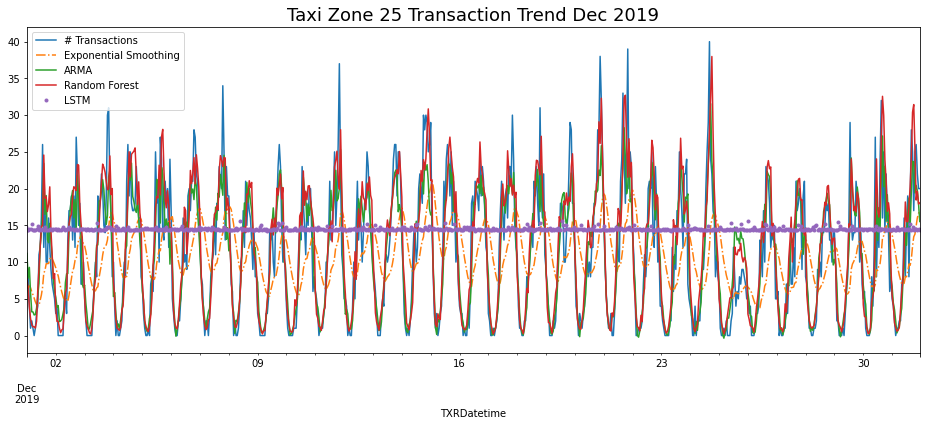

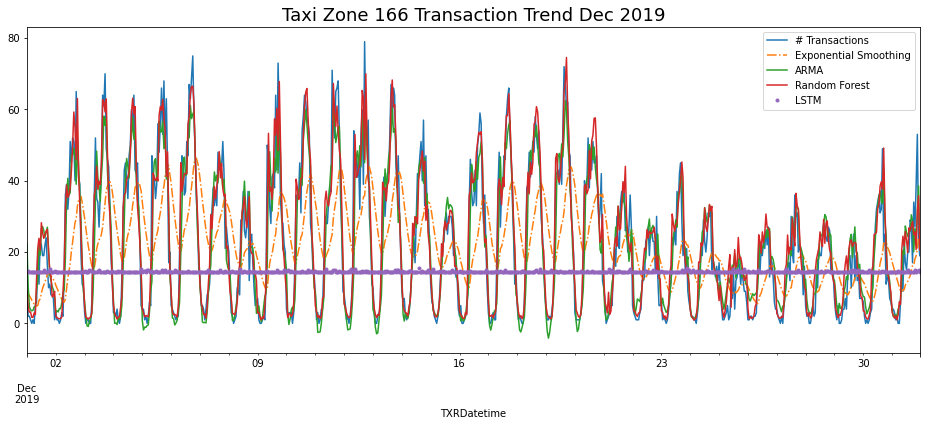

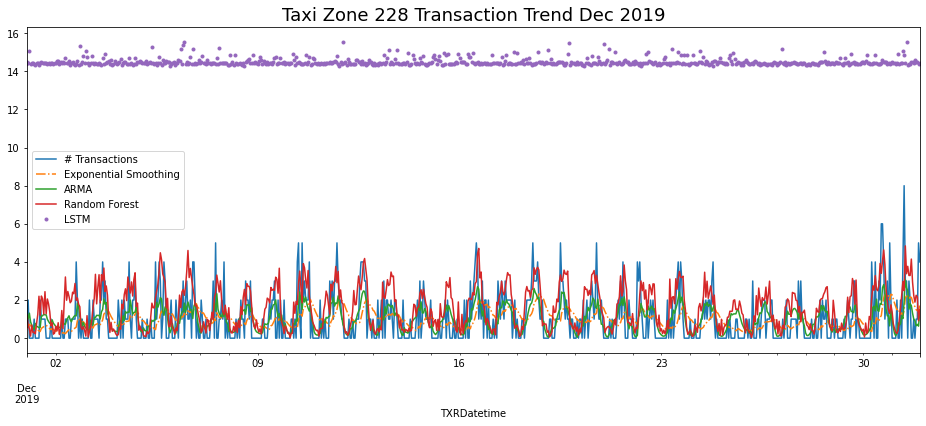

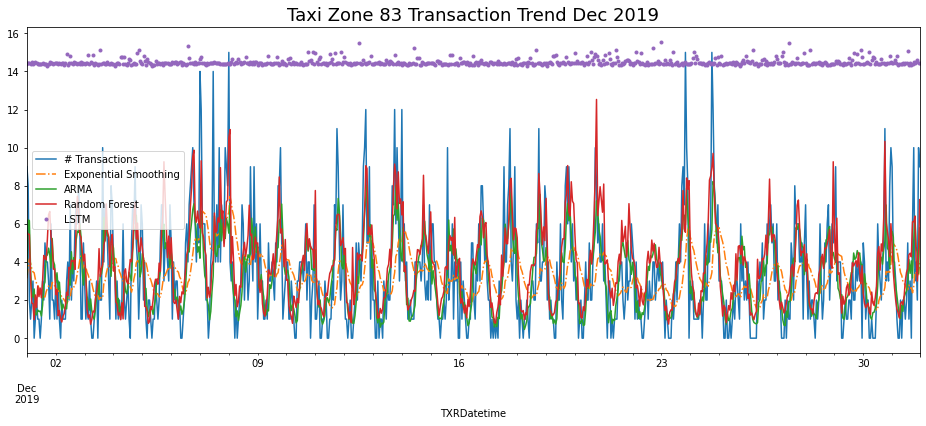

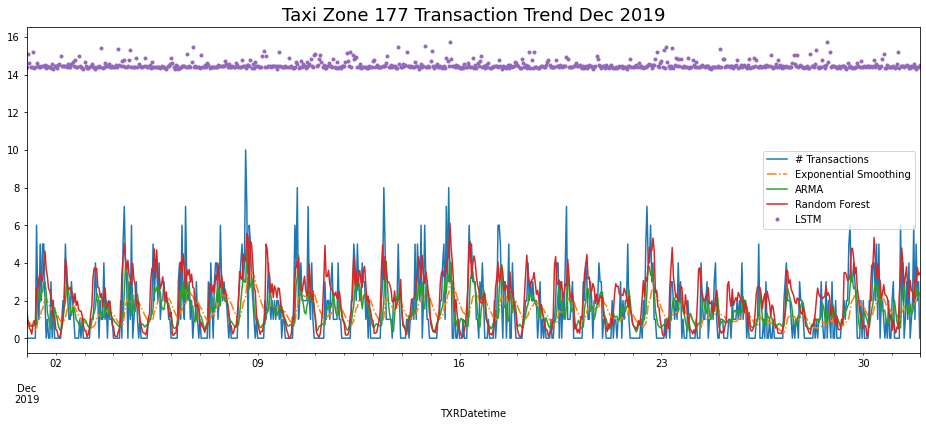

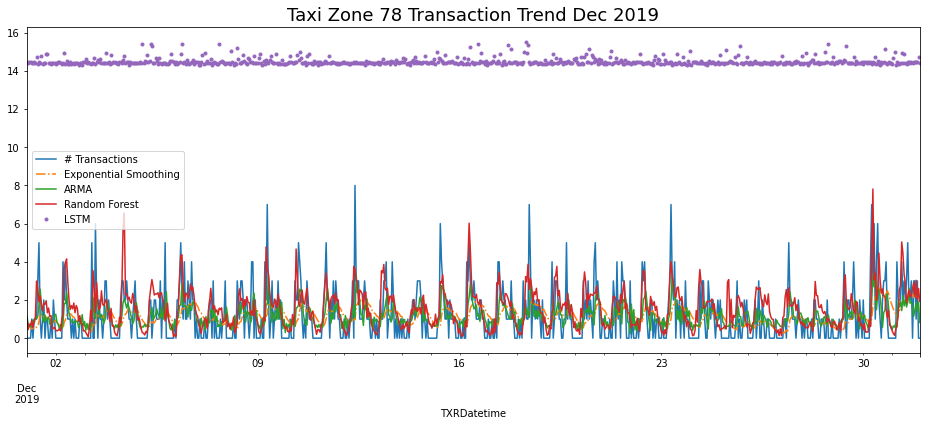

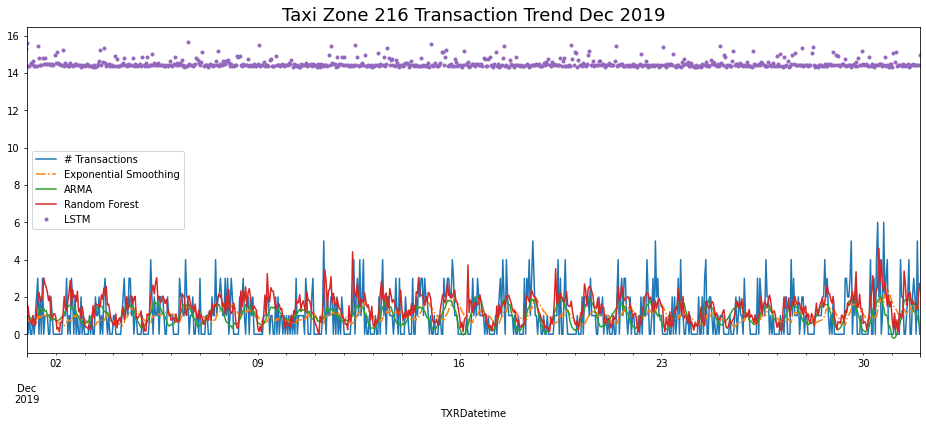

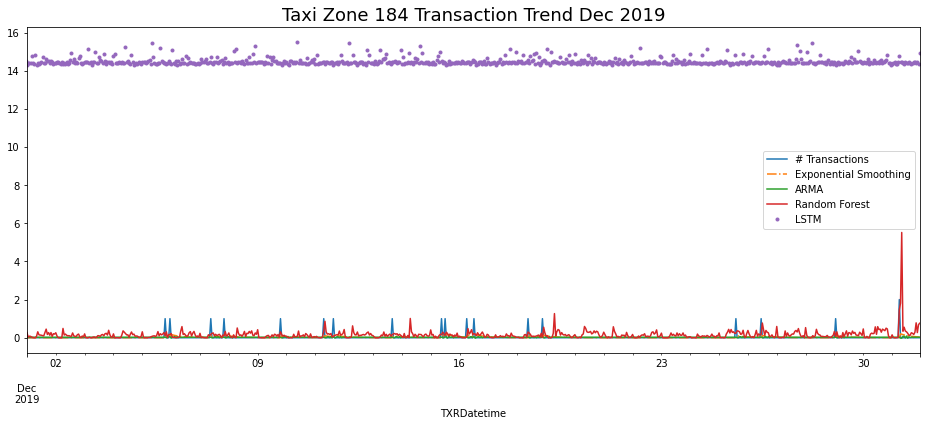

In [63]:
warnings.simplefilter('ignore')

for z in [25,166,228,83,177,78,216,184]:
    
    #Select December 2015 data
    TSData_zone = DS[DS['PULocationID']==z].copy()   
    TSData_zone = TSData_zone[(TSData_zone['Yr']==2019)&(TSData_zone['Month']==12)]
    

    TSData_zone = TSData_zone.set_index('TXRDatetime')
    TSData_zone.index = pd.DatetimeIndex(TSData_zone.index).to_period('h')
    TSData_zone = TSData_zone[['# Transactions']]    
    
    #Exponential Smoothing
    model_ExpSmooth = SimpleExpSmoothing(TSData_zone)
    model_ExpSmooth_fit = model_ExpSmooth.fit(smoothing_level=.1)
    

    #ARMA
    model_ARMA = ARIMA(TSData_zone, order=(2, 0, 6))  
    results_ARMA = model_ARMA.fit()        

    #Random Forest
    TestSet_zone = TestSet[TestSet['PULocationID']==z].copy()    
    predictionRF_zone = regressor.predict(TestSet_zone[Features_clmn])    
    
    TestSet_zone['RF Prediction'] = predictionRF_zone
    TestSet_zone = TestSet_zone.set_index('TXRDatetime')
    RF_Pred_df = TestSet_zone[['RF Prediction']].copy()
    RF_Pred_df.index = pd.DatetimeIndex(RF_Pred_df.index).to_period('h')
    
    
    #LSTM
    LSTM_Prediction_zone = LSTM_Prediction[LSTM_Prediction['PULocationID']==z].copy()
    LSTM_Prediction_zone = LSTM_Prediction_zone[['Model forecast']].copy()
    LSTM_Prediction_zone.index = pd.DatetimeIndex(LSTM_Prediction_zone.index).to_period('h')

    TSData_zone.plot(figsize = (16,6))
    plt.title('Taxi Zone ' + str(z) + ' Transaction Trend Dec 2019', fontsize=18)
    plt.plot(model_ExpSmooth_fit.fittedvalues, '-.', label="Exponential Smoothing")
    plt.plot(results_ARMA.fittedvalues, '-', label="ARMA")   
    plt.plot(RF_Pred_df, '-', label="Random Forest")    
    plt.plot(LSTM_Prediction_zone['Model forecast'], '.', label="LSTM")    
    plt.legend()
    plt.savefig('Taxi Zone '+ str(z) + ' Prediction Result.jpg')
    plt.show()